### Introduction: This is the Jupyter notebook to do the flowing things:

1. Read slimmed PKU Tree files to plot variables distribution

Enviroment needed for this script: HWW

(I have exported the enviroment needed for this script, assume you have `Conda` installed in your terminal, then enter `../envs/` directory, and use  `conda env create -f HWW.yml` to create the enviroment)




### Import necessary modules

In [2]:
import numpy as np
import os
import pandas as pd
import random
import awkward as ak
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from scipy import interpolate
from cycler import cycler
import uproot
import ROOT
import argparse
import glob
import json
import logging
import os
import pickle as pkl
import warnings
import hist as hist2
import pyarrow
import yaml
from typing import Dict, List, Union
from dataclasses import dataclass
from copy import deepcopy
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.nanoevents.methods import vector


### Read SlimmedTree files

In [3]:
#load the slimmedtree files using uproot

#different year available here.
# year = "2016"
# year = "2017"
# year = "2018"
year = "Full-Run2"

#if run on PKU cluster, use this:
# CustNanoData = {
#     'data'        : "/data/bond/zhaoyz/SlimmedTree/V5/%s/Data/SlimmedTree_Data.root"%(year),
#     'QCD'         : "/data/bond/zhaoyz/SlimmedTree/V5/%s/MC/SlimmedTree_QCD.root"%(year),
#     'Top'         : "/data/bond/zhaoyz/SlimmedTree/V5/%s/MC/SlimmedTree_Top.root"%(year),
#     'WJets'       : "/data/bond/zhaoyz/SlimmedTree/V5/%s/MC/SlimmedTree_WJets.root"%(year),
#     'Rest'        : "/data/bond/zhaoyz/SlimmedTree/V5/%s/MC/SlimmedTree_Rest.root"%(year),
#     'TotalSignal' : "/data/bond/zhaoyz/SlimmedTree/V5/%s/Signal/SlimmedTree_Total.root"%(year),
#     'ggF'         : "/data/bond/zhaoyz/SlimmedTree/V5/%s/Signal/SlimmedTree_GluGlu.root"%(year),
#     'VH'          : "/data/bond/zhaoyz/SlimmedTree/V5/%s/Signal/SlimmedTree_VH.root"%(year),
#     'ttH'         : "/data/bond/zhaoyz/SlimmedTree/V5/%s/Signal/SlimmedTree_ttH.root"%(year),
#     'VBF'         : "/data/bond/zhaoyz/SlimmedTree/V5/%s/Signal/SlimmedTree_VBF.root"%(year),
# } 

#if run on lxplus, use this:
CustNanoData = {
    'data'        : "/eos/user/y/yuzhe/HWW/SlimmedTree/V5/%s/Data/SlimmedTree_Data.root"%(year),
    'QCD'         : "/eos/user/y/yuzhe/HWW/SlimmedTree/V5/%s/MC/SlimmedTree_QCD.root"%(year),
    'Top'         : "/eos/user/y/yuzhe/HWW/SlimmedTree/V5/%s/MC/SlimmedTree_Top.root"%(year),
    'WJets'       : "/eos/user/y/yuzhe/HWW/SlimmedTree/V5/%s/MC/SlimmedTree_WJets.root"%(year),
    'Rest'        : "/eos/user/y/yuzhe/HWW/SlimmedTree/V5/%s/MC/SlimmedTree_Rest.root"%(year),
    'TotalSignal' : "/eos/user/y/yuzhe/HWW/SlimmedTree/V5/%s/Signal/SlimmedTree_Total.root"%(year),
    'ggF'         : "/eos/user/y/yuzhe/HWW/SlimmedTree/V5/%s/Signal/SlimmedTree_GluGlu.root"%(year),
    'VH'          : "/eos/user/y/yuzhe/HWW/SlimmedTree/V5/%s/Signal/SlimmedTree_VH.root"%(year),
    'ttH'         : "/eos/user/y/yuzhe/HWW/SlimmedTree/V5/%s/Signal/SlimmedTree_ttH.root"%(year),
    'VBF'         : "/eos/user/y/yuzhe/HWW/SlimmedTree/V5/%s/Signal/SlimmedTree_VBF.root"%(year),
}     


BKG = ["QCD","Top","WJets","Rest"]
files = {typefile : {} for typefile in CustNanoData}
for typefile in CustNanoData:
    files[typefile] = uproot.lazy({CustNanoData[typefile]: "PKUTree" })
    
#for signal decomposition plots, we store these information in different objects
files[r"$H^{4q}$"] = files["TotalSignal"][files["TotalSignal"]["R4q_a"] == 1]
files[r"$H^{3q}$"] = files["TotalSignal"][(files["TotalSignal"]["R3q_a"] == 1) & (files["TotalSignal"]["R3q_taudecay_a"] != 1)]
files["W"] = files["TotalSignal"][files["TotalSignal"]["w_a"] == 1]
files["top"] = files["TotalSignal"][files["TotalSignal"]["t_a"] == 1]
files["Z"] = files["TotalSignal"][files["TotalSignal"]["z_a"] == 1]
files[r"$H^{lqq}$"] = files["TotalSignal"][(files["TotalSignal"]["Rlqq_a"] == 1) | (files["TotalSignal"]["R3q_taudecay_a"] == 1)]
files["g/q"] = files["TotalSignal"][files["TotalSignal"]["gKK_g_a"] == 1]
files["rest"] = files["TotalSignal"][(files["TotalSignal"]["u_a"] == 1) | (files["TotalSignal"]["Rlq_a"] == 1) | (files["TotalSignal"]["R2q_a"] == 1)]


### Get DPhi in the events

In [4]:
def get_dphi(events):
    pT_higgs   = events["PTj_V2_a"]
    eta_higgs  = events["Etaj_V2_a"]
    phi_higgs  = events["Phij_V2_a"]
    mass_higgs = events["Mj_V2_a"]
    pT_MET = events["MET_et"]
    eta_MET = events["Etaj_V2_a"]
    phi_MET = events["MET_phi"]
    mass_MET = ak.zeros_like(events["MET_phi"])
    vec_higgs = ak.zip({
        "pt"   : pT_higgs   ,
        "eta"  : eta_higgs  ,
        "phi"  : phi_higgs  ,
        "mass" : mass_higgs ,
    },
    with_name="PtEtaPhiMLorentzVector",
    behavior=vector.behavior,
    )
    vec_MET = ak.zip({
        "pt"   :   pT_MET   ,
        "eta"  :  eta_MET  ,
        "phi"  :  phi_MET  ,
        "mass" : mass_MET ,
    },
    with_name="PtEtaPhiMLorentzVector",
    behavior=vector.behavior,
    )
    delta_phi = np.subtract(vec_MET.phi, vec_higgs.phi)
    delta_phi = np.where(delta_phi > np.pi, delta_phi - 2*np.pi, delta_phi)
    delta_phi = np.where(delta_phi < -np.pi, delta_phi + 2*np.pi, delta_phi)
    delta_phi = np.abs(delta_phi)
    print(delta_phi)
    events["DPhi"] = delta_phi

for k in files:
    print("Add dphi of:",k)
    get_dphi(events=files[k])

Add dphi of: data


[0.597, 0.363, 0.458, 1.07, 2.84, 0.341, ... 0.767, 0.2, 0.504, 3.03, 0.289, 0.0353]
Add dphi of: QCD
[2.8, 2.58, 0.514, 2.3, 3.01, 0.305, 0.629, ... 0.0396, 3.07, 0.765, 3, 2.96, 3.07]
Add dphi of: Top
[0.377, 0.707, 0.49, 2.48, 2.35, 2.75, 2.95, ... 0.169, 2.6, 2.94, 1.61, 1.35, 3.05]
Add dphi of: WJets
[2.81, 0.123, 1.6, 0.0544, 2.76, 2.51, ... 2.74, 0.508, 2.42, 1.41, 2.56, 0.258]
Add dphi of: Rest
[2.56, 1.73, 0.401, 3.13, 3.03, 2.83, 1.66, ... 1.26, 1.24, 0.0949, 2.46, 1.87, 2.91]
Add dphi of: TotalSignal
[2.4, 1.87, 3.06, 3.04, 2.91, 1.51, 2.08, ... 3.1, 0.141, 0.273, 0.498, 1.18, 2.73]
Add dphi of: ggF
[2.4, 1.87, 3.06, 3.04, 2.91, 1.51, 2.08, ... 3.09, 0.722, 3, 3.11, 3.07, 0.455]
Add dphi of: VH
[0.168, 1.39, 2.76, 1.26, 0.0118, 2.83, ... 3.1, 0.141, 0.273, 0.498, 1.18, 2.73]
Add dphi of: ttH
[3.12, 2.62, 2.28, 2.03, 0.0168, 0.16, ... 0.743, 0.839, 2.31, 2.44, 2.99, 0.506]
Add dphi of: VBF
[2.97, 2.31, 0.0849, 0.17, 0.0194, 0.481, ... 1.13, 0.332, 2.5, 2.82, 2.01, 2.45]
Add d

### Get MET recovery mass

In [5]:

def get_reco(events):
    pT_higgs   = events["PTj_V2_a"]
    eta_higgs  = events["Etaj_V2_a"]
    phi_higgs  = events["Phij_V2_a"]
    mass_higgs = events["Mj_V2_a"]
    pT_MET = events["MET_et"]
    eta_MET = events["Etaj_V2_a"]
    phi_MET = events["MET_phi"]
    mass_MET = ak.zeros_like(events["MET_phi"])
    vec_higgs = ak.zip({
        "pt"   : pT_higgs   ,
        "eta"  : eta_higgs  ,
        "phi"  : phi_higgs  ,
        "mass" : mass_higgs ,
    },
    with_name="PtEtaPhiMLorentzVector",
    behavior=vector.behavior,
    )

    vec_MET = ak.zip({
        "pt"   :   pT_MET   ,
        "eta"  :  eta_MET  ,
        "phi"  :  phi_MET  ,
        "mass" : mass_MET ,
    },
    with_name="PtEtaPhiMLorentzVector",
    behavior=vector.behavior,
    )

    vec_sum = vec_MET + vec_higgs
    mH_reco = vec_sum.mass
    events["MH_Reco"] = ak.where(( (events["DPhi"] < 0.8) & (events["MET_et"]/events["PTj_V2_a"] > 0.1)),mH_reco, events["Mj_V2_a"])

for k in files:
    print("Add reco of:",k)
    get_reco(events=files[k])

Add reco of: data
Add reco of: QCD
Add reco of: Top
Add reco of: WJets
Add reco of: Rest
Add reco of: TotalSignal
Add reco of: ggF
Add reco of: VH
Add reco of: ttH
Add reco of: VBF
Add reco of: $H^{4q}$
Add reco of: $H^{3q}$
Add reco of: W
Add reco of: top
Add reco of: Z
Add reco of: $H^{lqq}$
Add reco of: g/q
Add reco of: rest


### output all the variables for which we can make plots

In [6]:
files["VBF"].fields

['PTj_min',
 'Etaj_min',
 'R4q_a',
 'Phij',
 'a_Htauhtauh',
 'Mj_corr',
 'nb_t_deep_in',
 'Etaj_2',
 'R4q_c',
 'a_TopbWtauhv',
 'R3q_taudecay_b',
 'Mj_corr_a',
 'a_TopbWtauev',
 'w_a',
 'MET_et',
 'a_HWqqWtauhv0c',
 'a_QCDbb',
 'Etaj_V2_c',
 'Phij_mid',
 'R2q_a',
 'a_HWqqWtaumv0c',
 'a_Hbb',
 'Etaj_V2_a',
 'a_QCDc',
 'MJJ',
 'gKK_g_c',
 'Mj_mid',
 'PTj',
 'SF',
 'Mj_V2_b',
 'Rlqq_c',
 'Phij_max',
 'a_TopbWqq1c',
 'a_Hss',
 'a_HWqqWqq0c',
 'a_HWqqWmv1c',
 'MJJJ',
 'R2q_b',
 'a_HWW_V2',
 'PTj_V2_a',
 'nb_t_deep_ex',
 'a_HWqqWtaumv1c',
 'R2q_c',
 'PTj_3',
 'Etaj_V2_b',
 'R3q_c',
 'a_Htauhtaum',
 'Mj_corr_2',
 'ST',
 'Etaj_3',
 'Etaj_max',
 'Mj_min',
 'MET_T1Smear_phi_XYcorr',
 'PTj_2',
 'a_HWqqWq1c',
 'Rlq_b',
 'z_a',
 'Nj4_in',
 'a_HWqqWtauev1c',
 'Mj_V2_a',
 'Mj_corr_c',
 'Etaj_mid',
 'a_TopbWqq0c',
 'a_HWqqWmv0c',
 'Phij_V2_b',
 'Phij_min',
 'Phij_2',
 'nb_m_deep_ex',
 'Mj_max',
 'R4q_b',
 'weight',
 'Mj',
 't_c',
 'Phij_V2_a',
 'a_QCDb',
 'a_Hqq',
 'b_HWWvsQCD_V2',
 'nb_l_deep_in',
 '

### plot setting, error setting, histogram setting

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from cycler import cycler

use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

def flow(hist: bh.Histogram, overflow: bool=True, underflow: bool=True):
    h, var = hist.view(flow=(overflow | underflow)).value, hist.view(flow=(overflow | underflow)).variance
    if overflow: 
        # h, var also include underflow bins but in plots usually no underflow data
        # And we've filled None with -999, so we shouldn't show underflow data (mostly from filled None)
        # You have to access the overflow and underflow bins data like below:
        h[-2] += h[-1]; var[-2] += var[-1]
    if underflow:
        h[1] += h[0]; var[1] += var[0]
    if overflow or underflow:
        h, var = h[1:-1], var[1:-1]
    return h, var
    # Return the updated histogram and variance

def error_bar(h, var, type='data'):
    from scipy.interpolate import CubicSpline
    if type == 'data':
        number = h
    elif type == 'mc':  # h = k*N, var = k^2*N, std = k*sqrt(N)
        number = h**2 / var
    else:
        raise ValueError("type should be 'data' or 'mc'! ")
    center = range(11) # Number: 0-10
    up = np.array([1.84, 3.30, 4.64, 5.92, 7.16, 8.38, 9.58, 10.77, 11.95, 13.11, 14.27]) - center
    down = center - np.array([0, 0.17, 0.71, 1.37, 2.09, 2.84, 3.62, 4.42, 5.23, 6.06, 6.89])
    #cs means to create a CubicSpline object
    cs_up = CubicSpline(x=center, y=up)
    cs_down = CubicSpline(x=center, y=down)
    
    Garwood = (number>0)&(number<10)
    poison_error_bar = np.sqrt(number)
    up_error_bar = np.copy(poison_error_bar)
    down_error_bar = np.copy(poison_error_bar)
    up_error_bar[Garwood] = cs_up(number[Garwood])
    down_error_bar[Garwood] = cs_down(number[Garwood])
    if type == 'mc':
        up_error_bar *= var/h
        down_error_bar *= var/h
    up_error_bar [up_error_bar < 0 ] = 0
    down_error_bar [down_error_bar < 0 ] = 0
    return np.array([down_error_bar, up_error_bar])


# function to find the optimal region with S/sqrt(B)
# not used so far
def optimalcut(shist, bhist):
    n_bins = len(shist)
    best_lower = None
    best_upper = None
    best_s_sqrt_b = 0

    for lower in range(n_bins):
        for upper in range(lower+1, n_bins+1):
            s = np.sum(shist[lower:upper])
            b = np.sum(bhist[lower:upper])
            s_sqrt_b = s / np.sqrt(b + 1)

            if s_sqrt_b > best_s_sqrt_b:
                best_lower = lower
                best_upper = upper
                best_s_sqrt_b = s_sqrt_b

    return best_lower, best_upper, best_s_sqrt_b

def optimalcut_oneside(shist, bhist, epsilon = 0.01):
    '''
    Given the signal histogram and background histogram, 
    show the one-side cut for the variable to get best s/sqrt(b).
    Args:
        shist:signal histogram
        bhist:background histogram
        epsilon(float): epsilon to avoid numerical errs 
    '''
    n_bins = len(shist)
    best_cut = 0
    best_s_sqrt_b = 0

    for cut in range(n_bins):
        s = np.sum(shist[cut:])
        b = np.sum(bhist[cut:])
        s_sqrt_b = s / np.sqrt(b + epsilon)
        if s_sqrt_b > best_s_sqrt_b:
            best_cut = cut
            best_s_sqrt_b = s_sqrt_b
        
    return best_cut, best_s_sqrt_b

def optimalcut_mid_combine(shist1, shist2, bhist, epsilon = 1):
    '''
    Given the signal histogram and background histogram, 
    show the one-side cut for the variable to get best s/sqrt(b).
    Args:
        shist:signal histogram
        bhist:background histogram
        epsilon(float): epsilon to avoid numerical errs 
    '''
    n_bins = len(shist1)
    best_cut = 0
    best_combined_sig_two_side = 0

    for cut in range(n_bins):
        s_right_side = np.sum(shist2[cut:])
        b_right_side = np.sum(bhist[cut:])
        s_left_side = np.sum(shist1[:cut])
        b_left_side = np.sum(bhist[:cut])
        s_sqrt_b_right_side = s_right_side / np.sqrt(b_right_side + epsilon)
        s_sqrt_b_left_side = s_left_side / np.sqrt(b_left_side + epsilon)
        combined_sig_two_side = np.sqrt((s_sqrt_b_right_side)**2 + (s_sqrt_b_left_side)**2)
        if combined_sig_two_side > best_combined_sig_two_side:
            best_cut = cut
            best_combined_sig_two_side = combined_sig_two_side
        
    return best_cut, best_combined_sig_two_side


### define main plots function

In [20]:
from matplotlib.cm import get_cmap
hep.style.use("CMS")
def makeplots(arrays, weight, plot_name: str, x_name: str, region = 'PS',othertext = "", year='2018', bins=40, x_min=0, x_max=2000, overflow=False, underflow=False, log = False, blind = False,  nametext = "" ,optimal_cut = True, deco = False):
    '''
    arrays: awkward array of the variable we want to plot
    weight: awkward array of the weight of each event
    plot_name: string of the plot name
    x_name: x-axis name
    region: the region we want to plot, according to the cut defined below
    othertext: string to be added in the plots
    year: year of the data used(2016, 2017, 2018, Full-Run2)
    bins: number of bins
    x_min(max): range of the variables to be plotted
    overflow(underflow): bool variables, decide to use overflow/underflow or not, default set to False
    log: bool variable, decide to use log scale or not, default set to False
    blind: bool variable, decide to blind data or not, default set to False
    nametext: string to be added in the file name
    optimal_cut: bool variable, decide to plot optimal region or not, default set to True
    deco: bool variable, decide to plot signal decomposition or not, if False, will plot different production mode of signal, default set to False
    '''
    LUMI = {"2016": 36.33, "2017": 41.48, "2018": 59.83,"Full-Run2":138}
    bin_width = (x_max-x_min)/bins
    
    #blind data in this region
    if blind:
        mask = np.logical_or(arrays["data"] <= 90, arrays["data"] >= 150)
        arrays["data"] = arrays["data"][mask]
    
    # canvas initializing
    f = plt.figure(figsize=(9, 10))
    gs = mpl.gridspec.GridSpec(3, 1, height_ratios=[6, 1, 1], hspace=0.08)
    ax = f.add_subplot(gs[0])
    plt.grid()
    hep.cms.label(loc = 1, data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
   
    # ratio panel
    ax1 = f.add_subplot(gs[1])
    ax2 = f.add_subplot(gs[2])
    ax1.grid()
    ax2.grid()
        
    # analyze
    stacked = {'h': {}, 'var': {}} 
    individual = {'h': {}, 'var': {}}
    BKG = ["QCD","Top","WJets","Rest"]
    for (k,v) in arrays.items():
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        values = ak.fill_none(v, -999)
        if k!='data':
            hist.fill(values, weight=weight[k])
        else:
            hist.fill(values)
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
        if k in BKG: 
            stacked['h'][k] = h
            stacked['var'][k] = var
        else:
            individual['h'][k] = h
            individual['var'][k] = var        
    
    #plot
    SIG_COLOR={'TotalSignal': 'black',"ggF":"pink","VH":"blue","ttH":"yellow","VBF":"aqua"}
    SIG_DECO_COLOR = {'TotalSignal': 'black',r"$H^{4q}$":"green",r"$H^{3q}$":"orange","W":"blue","top":"purple","Z":"yellow",r"$H^{lqq}$":"cyan","g/q":"pink","rest":"gray"}
    ax1.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')
    if len(stacked['h'].keys())>0:
        BKG_list = ["Rest","WJets","Top","QCD"]
        err_list = [  np.nan_to_num(error_bar(stacked['h'][k], stacked['var'][k], type = "mc"), nan = 0) for k in BKG_list]
        h_list = [stacked['h'][k] for k in BKG_list]
        label_list = BKG_list
        colors = ["#1f77b4", "#ff7f0e", "#2ca02c","#d62728"]
        hep.histplot(h_list, bins=hist.axes[0].edges, label=label_list, yerr = err_list, histtype='fill', density=False, stack=True, linewidth=2, ax=ax,color = colors)
        bkg_h = np.sum(list(stacked['h'].values()), axis=0)
        bkg_err = np.sum(err_list ,  axis=0)
        bin_edges = np.linspace(x_min, x_max, bins+1)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        ax.errorbar(x = bin_centers,y = bkg_h, yerr=bkg_err, fmt='none', color='gray', capsize=2,markersize = 3)
    
    # Scale the signal according to total BKG to make it visiable:
    NORM_s1=np.sum(bkg_h)/(np.sum(individual["h"]["TotalSignal"])+0.000001)
    print("Should scale signal * ",NORM_s1)
    if                       NORM_s1>=300000: NORM_s1=300000
    elif  300000>NORM_s1 and NORM_s1>=100000: NORM_s1= 100000
    elif  100000>NORM_s1 and NORM_s1>= 30000: NORM_s1= 30000
    elif   30000>NORM_s1 and NORM_s1>= 10000: NORM_s1=  10000
    elif   10000>NORM_s1 and NORM_s1>=  3000: NORM_s1=  3000
    elif    3000>NORM_s1 and NORM_s1>=  1000: NORM_s1=   1000
    elif    1000>NORM_s1 and NORM_s1>=   300: NORM_s1=   300
    elif     300>NORM_s1 and NORM_s1>=   100: NORM_s1=    100
    elif     100>NORM_s1 and NORM_s1>=    30: NORM_s1=    30
    elif      30>NORM_s1 and NORM_s1>=    10: NORM_s1=     10
    else                                    : NORM_s1=     1   
    
    for (k,h) in individual['h'].items():
        if k=='data': #data
            err = error_bar(h, individual['var'][k], type='data')
            hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=k, color='black', histtype='errorbar', density=False, stack=False, ax=ax)
            ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
            hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=ratio_error, color='black', histtype='errorbar', density=False, stack=False, ax=ax1)    
            data_mc_ratio = np.sum(h)/np.sum(bkg_h)
        else:  # signal
            if deco != True: #plot signal in different production mode
                if k in ["TotalSignal","ggF","VH","ttH","VBF"]:
                    err = error_bar(h, individual['var'][k], type='mc')
                    hep.histplot(h*NORM_s1, bins=hist.axes[0].edges, yerr=NORM_s1*err, label=k+r"$\times$"+str(NORM_s1), histtype='step', density=False, stack=False, linewidth=2, ax=ax, color=SIG_COLOR[k])
                    y = h / np.sqrt(bkg_h + 1)
                    hep.histplot(y, bins=hist.axes[0].edges, yerr=err/np.sqrt(bkg_h+1), label=k, histtype='step', density=False, stack=False, ax=ax2, color=SIG_COLOR[k])
            
            else: #plot signal in signal decomposition mode
                if k not in ["ggF","VH","ttH","VBF"]:
                    frac = "(" + "%.1f"%(np.sum(h)/np.sum(individual['h']["TotalSignal"])*100)+ "%)"
                    err = error_bar(h, individual['var'][k], type='mc')
                    if k != "TotalSignal": hep.histplot(h*NORM_s1, bins=hist.axes[0].edges, yerr=NORM_s1*err, label=k+frac, histtype='step', density=False, stack=False, linewidth=2, ax=ax, color=SIG_DECO_COLOR[k])
                    else:hep.histplot(h*NORM_s1, bins=hist.axes[0].edges, yerr=NORM_s1*err, label=k+r"$\times$"+str(NORM_s1), histtype='step', density=False, stack=False, linewidth=2, ax=ax, color=SIG_DECO_COLOR[k])
                    y = h / np.sqrt(bkg_h + 1)
                    hep.histplot(y, bins=hist.axes[0].edges, yerr=err/np.sqrt(bkg_h+1), label=k, histtype='step', density=False, stack=False, ax=ax2, color=SIG_DECO_COLOR[k])
            
            if k == "TotalSignal": #print optimal cut information
                best_lower, best_upper, best_s_sqrt_b = optimalcut(h,bkg_h)
                print("Optimal two-side cut =",best_lower, best_upper, best_s_sqrt_b)
                best_cut, best_s_sqrt_b = optimalcut_oneside(h,bkg_h)
                print("Optimal one-side cut =",best_cut, best_s_sqrt_b) 
                best_cut, best_combined_sig_two_side = optimalcut_mid_combine(individual['h'][r"$H^{4q}$"],individual['h'][r"$H^{lqq}$"],bkg_h)
                print("Optimal mid-side cut = ",best_cut,best_combined_sig_two_side)
            
            if optimal_cut == True: #add optimal cut information in the plot
                cut_value_low = x_min + best_lower * (x_max - x_min)/bins
                ax2.axvline(x=cut_value_low, color='r', linestyle='-')
                ax2.annotate('', xy=(cut_value_low, ax2.get_ylim()[1]), xytext=(cut_value_low - (x_max - x_min)/20 , ax2.get_ylim()[1]),arrowprops=dict(facecolor='red', arrowstyle="->"))                
                cut_value_up = x_min + best_upper * (x_max - x_min)/bins
                ax2.axvline(x=cut_value_up, color='r', linestyle='-')
                ax2.annotate('', xy=(cut_value_up, ax2.get_ylim()[1]), xytext=(cut_value_up + (x_max - x_min)/20 , ax2.get_ylim()[1]),arrowprops=dict(facecolor='red', arrowstyle="->"))                
                if cut_value_low < (x_max - cut_value_up):
                    text_position = cut_value_up + (x_max - x_min)/20
                    ax2.text(text_position, ax2.get_ylim()[1], r'$S/\sqrt{B+1}$'+"=%s"%(str(round(best_s_sqrt_b,3))), verticalalignment='center', horizontalalignment='left',fontsize = 13)
                else: 
                    text_position = cut_value_low - (x_max - x_min)/20
                    ax2.text(text_position, ax2.get_ylim()[1], r'$S/\sqrt{B+1}$'+"=%s"%(str(round(best_s_sqrt_b,3))), verticalalignment='center', horizontalalignment='right',fontsize = 13)

    ax.set_xlim(x_min, x_max)
    
    # plot setting
    if log:
        ax.set_yscale('log')
        ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1]*1e1)
    else:
        ax.set_ylim(0.01, ax.get_ylim()[1]*1.3)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)

    
    # set the range of data/MC ratio plot
    ax1.set_xlim(x_min, x_max)
    ax1.set_xticklabels([])
    ax1.set_ylim(0, 2)
    ax1.set_ylabel(r'$\frac{Data}{bkg\ MC}$', ha='center', fontsize=24)
    ax1.tick_params(axis='both', which='major', labelsize=16)
    
    # set the range of s/sqrt(b) plot
    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(0, ax2.get_ylim()[1]*1.4)
    ax2.tick_params(axis='both', which='major', labelsize=16)
    ax2.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax2.set_ylabel(r'$S/\sqrt{B+1}$', ha='center', fontsize=16)
    ax2.ticklabel_format(useOffset=False, style='plain')
    ax2.tick_params(axis='both', which='major', labelsize=16)
    plt.xticks(size=14)
    plt.yticks(size=14)
    
    if blind:
        plt.text(0.05,0.83,region + " " + othertext + " blinded",fontsize=17, color="black", ha='left',transform=ax.transAxes)
    else:
        plt.text(0.05,0.83,region + othertext + " Data/MC = " + str(round(data_mc_ratio,3)),fontsize=17, color="black", ha='left',transform=ax.transAxes)        
    ax.legend(loc="upper right", ncol=2, frameon=False, fontsize=13)
    
    # suffix in filename
    suffix = ''
    if deco: suffix += "_DECO"
    
    #change this string to set the path
    path_str = './plots/makeplots/02Feb2024'
    if not os.path.exists(path_str):
        os.makedirs(path_str)
    plt.savefig(f"{path_str}/{year}_{plot_name}{suffix}_{region}_{othertext}_{nametext}.pdf", bbox_inches='tight')
    plt.show()

### define the cut for each regions, for examples, SRs, CRs, PS and MET regions here:

In [9]:
CUT = {        
    "SR1a" : {k:  (files[k]["MH_Reco"] >= 50) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] <= 0.25) & (files[k]["a_HWW_V2"] >= 0.99) for k in files}, 
    "SR1b" : {k:  (files[k]["MH_Reco"] >= 50) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] <= 0.25) & (files[k]["a_HWW_V2"] >= 0.92) & (files[k]["a_HWW_V2"] < 0.99) for k in files},   
    "SR2a" : {k:  (files[k]["MH_Reco"] >= 50) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] > 0.25) & (files[k]["a_HWW_V2"] >= 0.99) & (files[k]["DPhi"] < 0.8)for k in files}, 
    "SR2b" : {k:  (files[k]["MH_Reco"] >= 50) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] > 0.25) & (files[k]["a_HWW_V2"] >= 0.92) & (files[k]["a_HWW_V2"] < 0.99) & (files[k]["DPhi"] < 0.8)for k in files},   
    "CR1"  : {k:  (files[k]["MH_Reco"] >= 50) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] <= 0.25) & (files[k]["a_HWW_V2"] < 0.92) for k in files},
    "CR2"  : {k:  (files[k]["MH_Reco"] >= 50) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] > 0.25)  & (files[k]["a_HWW_V2"] < 0.92) & (files[k]["DPhi"] < 0.8) for k in files},   
    "PS"   : {k:  (files[k]["MH_Reco"] >= 0)  for k in files}, 
    "LowMET"   : {k:  (files[k]["MET_et"]/files[k]["PTj_V2_a"] <= 0.25)  for k in files},
    "HighMET"  : {k:  (files[k]["MET_et"]/files[k]["PTj_V2_a"] > 0.25)   for k in files},   
    }

# CR: tagger < 0.92

### define the variables we want to plot

In [17]:
def run_makeplots(region = "PS", events = files, nametext = "", blind = False, othertext = "", deco = False, optimal_cut = True):
    weight={k: events[k][CUT[region][k]]["weight"] for k in events}  # weight for each event
    makeplots(arrays = {k: events[k][CUT[region][k]]["MH_Reco"] for k in events},  region = region, nametext = nametext, othertext = othertext,plot_name='MH_Reco', x_name=r'$jet_{a}:MET-recovery\, Mass$', x_max=250, x_min=50, bins=20, weight =weight, year="Full-Run2",blind = blind, deco = deco,optimal_cut = optimal_cut)
    # add the variables you want to plot here, like above.

### make plots for each region, some examples are shown here

Should scale signal *  383.025854285164
Optimal two-side cut = 3 10 0.37881415006831864
Optimal one-side cut = 1 0.3323086839580462
Optimal mid-side cut =  1 0.20829217082914958


/tmp/ipykernel_1784029/3568017789.py:97: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_1784029/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1784029/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1784029/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


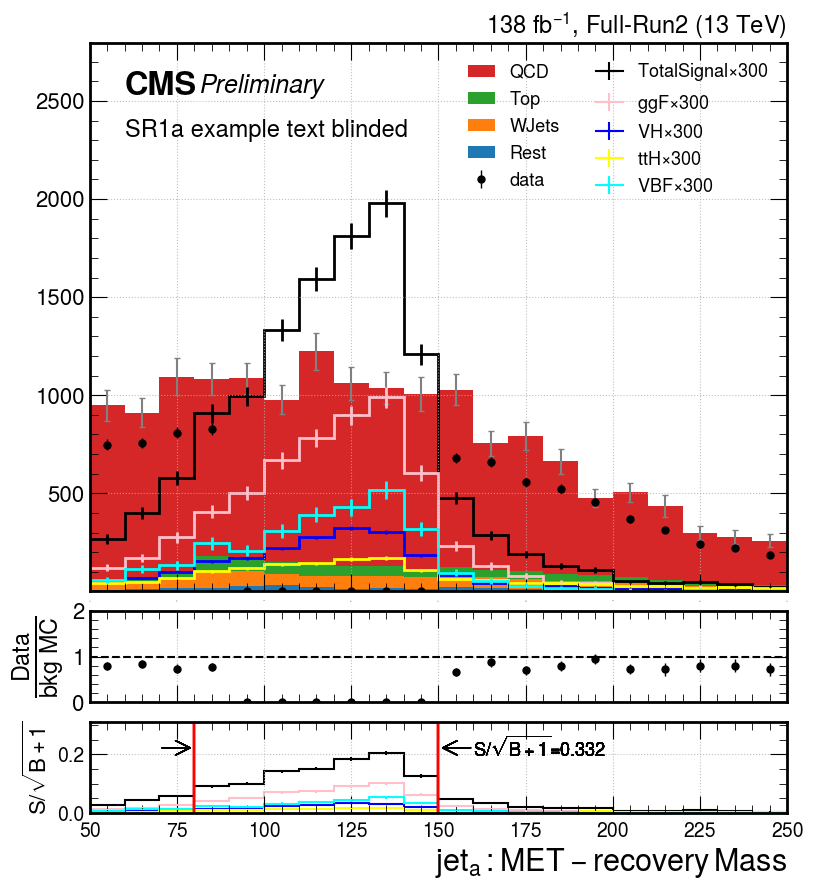

Should scale signal *  156859.34119467338
Optimal two-side cut = 2 20 0.07679361475939905
Optimal one-side cut = 2 0.07679361509069695
Optimal mid-side cut =  19 0.023859002370648398


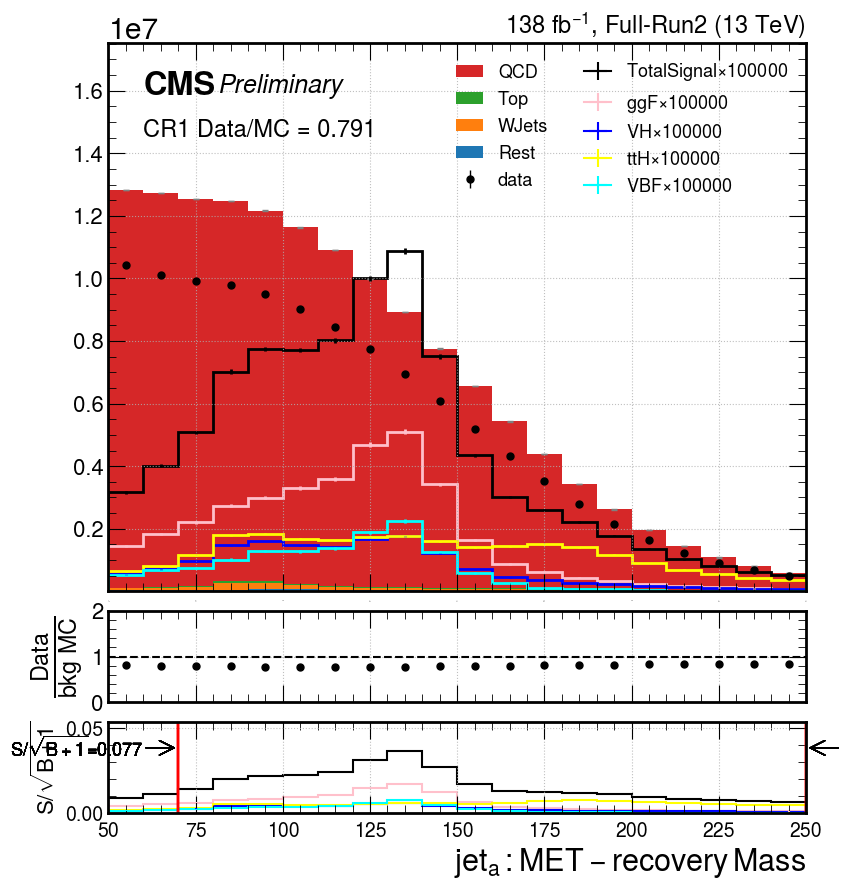

/tmp/ipykernel_1784029/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1784029/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1784029/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_1784029/3568017789.py:97: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_1784029/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1784029/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1784029/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_1784029/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1784029/314

Should scale signal *  49.05497446967979
Optimal two-side cut = 2 10 0.724974966390668
Optimal one-side cut = 0 0.6267207487099435
Optimal mid-side cut =  2 0.5831321275086299


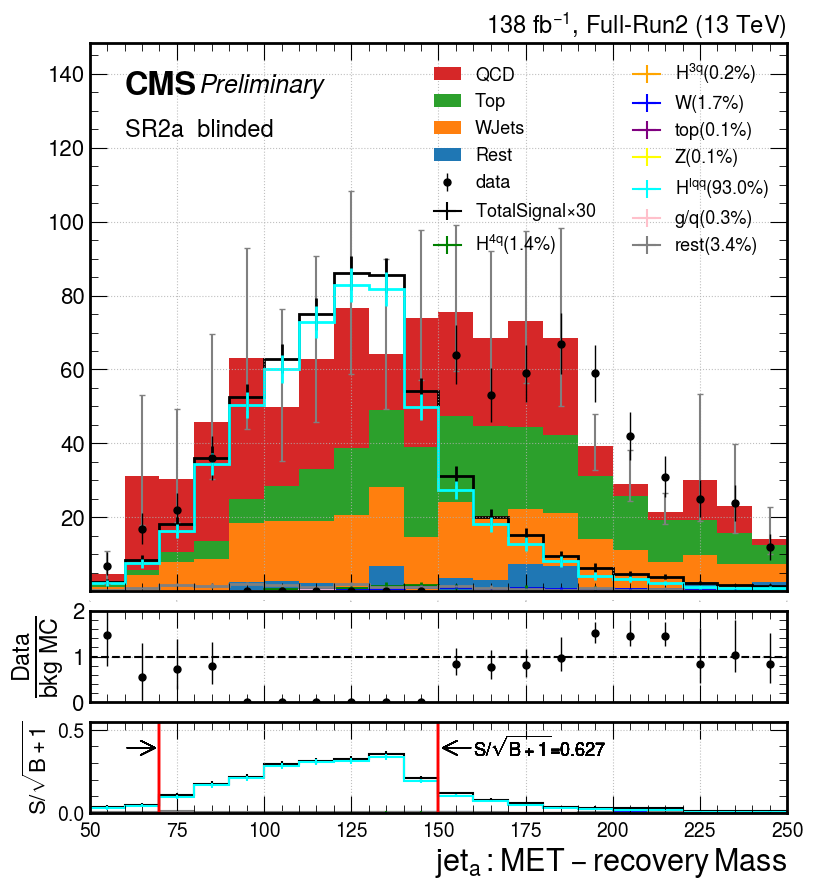

Should scale signal *  659.4327325337634
Optimal two-side cut = 0 20 0.21545512591906046
Optimal one-side cut = 0 0.21546040891511153
Optimal mid-side cut =  1 0.16276983310901497


/tmp/ipykernel_1784029/3568017789.py:97: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_1784029/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_1784029/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_1784029/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


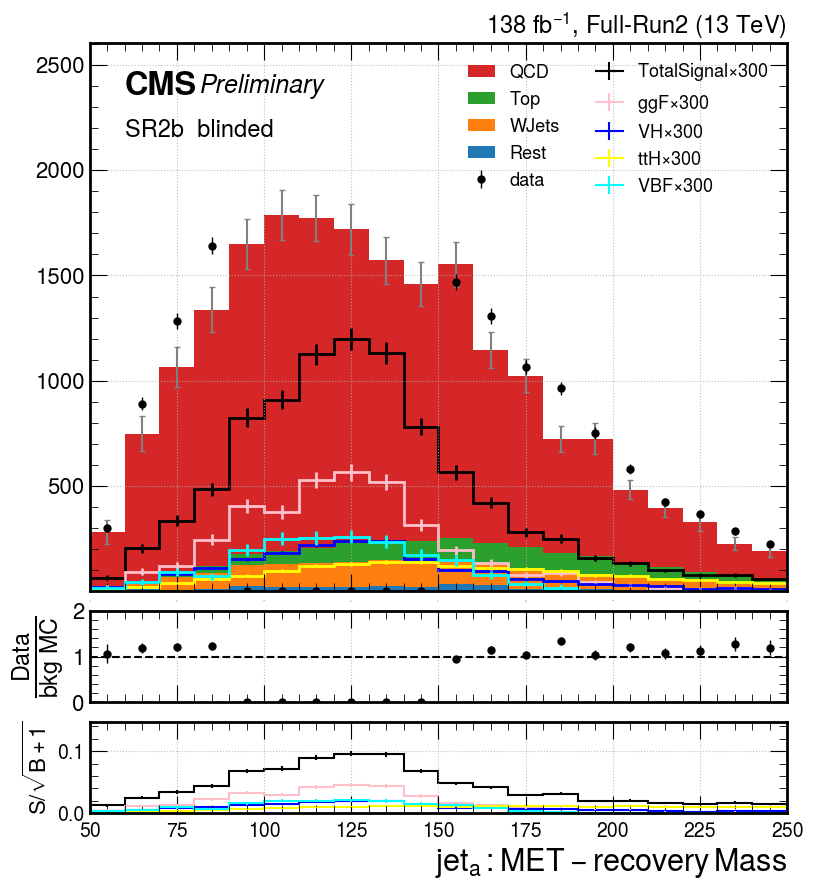

In [21]:
run_makeplots(region = "SR1a", blind = True,  othertext = "example text") #this will lead to the string "example text" added in the plot
run_makeplots(region = "CR1",  blind = False, othertext = "") #this will show full data/MC results
run_makeplots(region = "SR2a", blind = True,  othertext = "", deco = True) #this set to deco to True
run_makeplots(region = "SR2b", blind = True,  othertext = "", optimal_cut = False) #this won't show optimal cut plots